# Connect to Database

In [24]:
from query_database import QueryDatabase

df = QueryDatabase("SELECT * FROM supplier_invoice.invoice_202408;").df
# .df 表示查询结果被返回为一个 Pandas DataFrame.
df.head()


,Förvaltning,Leverantör,Organisationsnummer,Verifikationsnummer,Konto,Kontotext,Belopp exkl moms
0,Stadsmiljönämnden,TRACK TEC GMBH,106/5727/0626,4001291513,4101,Inköp anläggnings och underhållsmaterial,"9 835 315,00"
1,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378982,6185,Anläggningsentreprenad,"870,00"
2,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601377374,6185,Anläggningsentreprenad,"870,00"
3,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378519,6185,Anläggningsentreprenad,"870,00"
4,Exploateringsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,2001226894,7641,Diverse skatter och offentliga avgifter,"1 000,00"


In [6]:
# show how much data
df.shape


(92989, 7)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92989 entries, 0 to 92988
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Förvaltning          92989 non-null  object
 1   Leverantör           92989 non-null  object
 2   Organisationsnummer  92843 non-null  object
 3   Verifikationsnummer  92989 non-null  int64 
 4   Konto                92989 non-null  int64 
 5   Kontotext            92989 non-null  object
 6   Belopp exkl moms     92989 non-null  object
dtypes: int64(2), object(5)
memory usage: 5.0+ MB


## clean cost column

In [28]:
df[ "Belopp exkl moms"]

0        9 835 315,00
1              870,00
2              870,00
3              870,00
4            1 000,00
             ...     
92984     -263 400,00
92985      263 400,00
92986       23 518,07
92987       -5 879,52
92988       45 288,75
Name: Belopp exkl moms, Length: 92989, dtype: object

In [13]:
# 取 df 中 的 Belopp exkl moms 这一列， df 是 8月份表格的 DataFrame       straightforward 直截了当

df.loc[:, "Belopp exkl moms"] = df["Belopp exkl moms"].str[:-3].str.replace(" ", "").astype(int)

# .str[:-3] 去掉后3位, .str.replace(" ", "") 去掉空格, .astype(int) 格式从 object 变成 int
# object 类型 是 Pandas 中的通用数据类型，它通常用于存储文本数据（字符串），DataFrame 中的某一列包含混合类型的数据（如字符串、整数、浮动小数等）
# df.loc[:, "Belopp exkl moms"]：把新更改的值给 「选择所有的行, Belopp exkl moms 列」

df.head()

,Förvaltning,Leverantör,Organisationsnummer,Verifikationsnummer,Konto,Kontotext,Belopp exkl moms
0,Stadsmiljönämnden,TRACK TEC GMBH,106/5727/0626,4001291513,4101,Inköp anläggnings och underhållsmaterial,9835315
1,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378982,6185,Anläggningsentreprenad,870
2,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601377374,6185,Anläggningsentreprenad,870
3,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378519,6185,Anläggningsentreprenad,870
4,Exploateringsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,2001226894,7641,Diverse skatter och offentliga avgifter,1000


In [15]:
from database2 import Database
from constants import DATABASE_PATH

with Database(DATABASE_PATH) as db:
    # can use df inside of suckdb
    db.connection.register('df', df)   # 'df' is defined name 
    # 调用了 db.connection 对象的 register 方法，注册到数据库连接中。'df' 是名称，df 是数据表（Pandas DataFrame 对象）

    db.query("CREATE SCHEMA IF NOT EXISTS refined_layer;")
    db.query(f"""
             CREATE TABLE IF NOT EXISTS refined_layer.invoice_202408
             as select * from df;
             """)

In [17]:
QueryDatabase("select * from refined_layer.invoice_202408;").df.head()

,Förvaltning,Leverantör,Organisationsnummer,Verifikationsnummer,Konto,Kontotext,Belopp exkl moms
0,Stadsmiljönämnden,TRACK TEC GMBH,106/5727/0626,4001291513,4101,Inköp anläggnings och underhållsmaterial,9835315
1,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378982,6185,Anläggningsentreprenad,870
2,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601377374,6185,Anläggningsentreprenad,870
3,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378519,6185,Anläggningsentreprenad,870
4,Exploateringsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,2001226894,7641,Diverse skatter och offentliga avgifter,1000


In [25]:
df_total_cost = QueryDatabase("""
              select 
                Leverantör, 
                sum("Belopp exkl moms") as "Summa (SEK)"
              from 
                refined_layer.invoice_202408 
              group by 
                Leverantör
              order by
                "Summa (SEK)"
              desc limit 10; 
              """).df

df_total_cost.head()

,Leverantör,Summa (SEK)
0,GÖTEBORGS STADS LEASING AB,62433766.0
1,KPA PENSIONSSERVICE AB,59741750.0
2,RÄDDNINGSTJÄNSTEN STORGÖTEBORG,55320824.0
3,PURAC AB,48603208.0
4,RENOVA,34435107.0


<Axes: title={'center': 'Total kostnad'}, ylabel='Leverantör'>

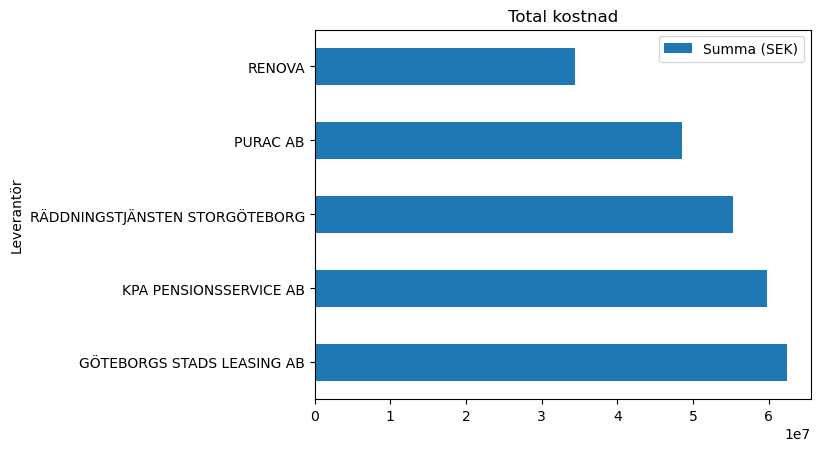

In [26]:
# 使用 Pandas 数据框绘图，它基于 matplotlib，允许快速可视化数据
# kind="barh" 指定绘制的是 水平柱状图（horizontal bar chart）。

df_total_cost.head().plot(kind = "barh", x = "Leverantör", y = "Summa (SEK)", title = "Total kostnad")

这段代码是正确的。它告诉 Pandas 将 Leverantör 显示在 y 轴，而 Summa (SEK) 用作 x 轴的长度。

x="Leverantör" ：指定 Leverantör 列为条形图的横轴标签，即条形图中每个条形代表的类别（供应商名称）。
y="Summa (SEK)"： 指定 Summa (SEK) 列为条形的长度，即每个供应商对应的总成本。
title="Total kostnad"

给图表添加标题为 “Total kostnad”（总成本）。


-- 效果图
横轴（条形的长度）：表示成本的数值（Summa (SEK)）。
纵轴（条形的类别）：表示供应商的名称（Leverantör）。
图表标题为 "Total kostnad"。

简单的对比：
图表类型	          x 轴	                y 轴
水平柱状图 barh	   数值（Summa）	      分类（Leverantör）
普通柱状图 bar	   分类（Leverantör）	  数值（Summa）

